In [5]:
import requests
import re
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

## Synonyms with Thesaurus API

In [6]:
keys = ["Production", "Retail", "Processing", "Distribution"]
#no_keys = [ "consumer discretionary", "consumer staples", "communication services"]

In [7]:
def get_synonyms_api(key_word):
    url = "https://www.dictionaryapi.com/api/v3/references/thesaurus/json/"
    key= "?key=bc125025-b3b8-4b13-b8e8-c1ef37845bad"
    syn_json = requests.get(url+key_word+key).json()
    syn_list = syn_json[0]['meta']['syns']
    if len(syn_list) > 1:
        master = sum(syn_list, [])
    elif len(syn_list) == 1:
        master = syn_list[0]
    master.append(key_word)
    return master

In [8]:
prod = get_synonyms_api(keys[0])
retail = get_synonyms_api(keys[1])
process = get_synonyms_api(keys[2])
distri =  get_synonyms_api(keys[3])
prod

['affair',
 'fruit',
 'handiwork',
 'labor',
 'output',
 'produce',
 'product',
 'thing',
 'work',
 'yield',
 'Production']

## Synonyms with NLP

In [9]:
def get_synonyms(phr):
    phr_syn_lst = [phr]
    phr_syn_lst = [i.name().lower() for syn in wordnet.synsets(phr) for i in syn.lemmas() ]

    return (list(set(phr_syn_lst)))    

In [10]:
get_synonyms("production")

['output', 'production', 'yield', 'product']

In [11]:
get_synonyms("retail")

['retail']

## Algorithm

In [12]:
df = pd.read_csv("scopus (4).csv")#, on_bad_lines='skip')
df.columns

Index(['Authors', 'Title', 'DOI', 'Link', 'Abstract', 'Author Keywords',
       'Index Keywords'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Authors          2000 non-null   object
 1   Title            2000 non-null   object
 2   DOI              1741 non-null   object
 3   Link             2000 non-null   object
 4   Abstract         2000 non-null   object
 5   Author Keywords  1544 non-null   object
 6   Index Keywords   1699 non-null   object
dtypes: object(7)
memory usage: 109.5+ KB


In [14]:
df = df.fillna("blank")

In [15]:
df.head(2)

,Authors,Title,DOI,Link,Abstract,Author Keywords,Index Keywords
0,Aalst W.M.P.,The Data Science Revolution: How Learning Mach...,10.1007/978-3-030-64246-4_2,https://www.scopus.com/inward/record.uri?eid=2...,Data science technology is rapidly changing th...,Artificial Intelligence; Big data; Data scienc...,Data Science; Decision making; Digital storage...
1,"Aarset M.V., Johannessen L.K.",On Distributed Cognition While Designing an AI...,10.3389/frai.2022.910630,https://www.scopus.com/inward/record.uri?eid=2...,"When analyzing learning, focus has traditional...",adaptive learning; artificial intelligence; di...,blank


In [16]:
non_alp = [';', ',', '(', ')', '[', ']', '.']
for i in non_alp:
    for col in ['Title','Abstract', 'Author Keywords', 'Index Keywords']:
        #df[col] = df[col].str.lower().replace(i,'')
        df[col] = df[col].map(lambda x: x.replace(i,''))

In [17]:
df.head(2)

,Authors,Title,DOI,Link,Abstract,Author Keywords,Index Keywords
0,Aalst W.M.P.,The Data Science Revolution: How Learning Mach...,10.1007/978-3-030-64246-4_2,https://www.scopus.com/inward/record.uri?eid=2...,Data science technology is rapidly changing th...,Artificial Intelligence Big data Data science ...,Data Science Decision making Digital storage M...
1,"Aarset M.V., Johannessen L.K.",On Distributed Cognition While Designing an AI...,10.3389/frai.2022.910630,https://www.scopus.com/inward/record.uri?eid=2...,When analyzing learning focus has traditionall...,adaptive learning artificial intelligence dist...,blank


In [18]:
df['content_sum'] = df['Abstract'] + df['Title'] + df['Author Keywords'] + df['Index Keywords']
#df['content_sum'].values[0].split()

In [19]:
df_copy = df.copy()

In [20]:
# Saving into a dictionary all of the syns
keys_dict = {}
for i in keys:
    keys_dict[i] = get_synonyms_api(i)
 
keys_dict

{'Production': ['affair',
  'fruit',
  'handiwork',
  'labor',
  'output',
  'produce',
  'product',
  'thing',
  'work',
  'yield',
  'Production'],
 'Retail': ['deal (in)',
  'market',
  'merchandise',
  'put up',
  'sell',
  'vend',
  'Retail'],
 'Processing': ['rectifying',
  'refining',
  'clarifying',
  'clearing',
  'distilling',
  'filtering',
  'fining',
  'garbling',
  'purifying',
  'cleaning',
  'cleansing',
  'decontaminating',
  'elutriating',
  'purging',
  'washing',
  'extracting',
  'leaching',
  'bolting',
  'screening',
  'sieving',
  'sifting',
  'disinfecting',
  'sanitizing',
  'reprocessing',
  'reusing',
  'reclaiming',
  'recovering',
  'recycling',
  'Processing'],
 'Distribution': ['admeasurement',
  'allocation',
  'allotment',
  'apportionment',
  'disbursement',
  'dispensation',
  'division',
  'issuance',
  'arrangement',
  'array',
  'disposal',
  'disposition',
  'order',
  'ordering',
  'sequence',
  'setup',
  'Distribution']}

In [21]:
# counting the keyworkds with their syns in all of the documents
for key in keys_dict.keys():
    df_copy[key] = 0
    for phr in keys_dict[key]:
        for i in range(len(df_copy)):
            if phr in (df_copy['content_sum'].values[i].split()):
                df_copy[key][i] += 1
    #df.loc[key, i] = count

<ipython-input-21-89572dbf2fbb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[key][i] += 1
<ipython-input-21-89572dbf2fbb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[key][i] += 1
<ipython-input-21-89572dbf2fbb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[key][i] += 1
<ipython-input-21-89572dbf2fbb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [22]:
df_copy["Production"].sum()
sum_dic = {}
for i in keys:
    sum_dic[i] = df_copy[i].sum()
 
sum_dic

{'Production': 693, 'Retail': 39, 'Processing': 206, 'Distribution': 381}

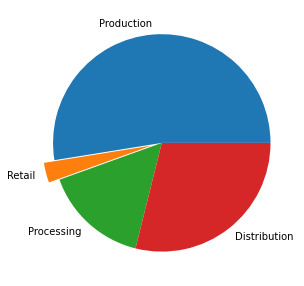

In [23]:
# create a figure and set different background
fig = plt.figure(figsize=(5,5))
fig.patch.set_facecolor('white')
 
# Change color of text
plt.rcParams['text.color'] = 'black'
 
# Pieplot + circle on it
plt.pie(sum_dic.values(), labels=sum_dic.keys(), explode=(0, 0.1, 0, 0))
p=plt.gcf()
plt.show()

In [24]:
df_copy.loc[df_copy["Production"] > 2]

,Authors,Title,DOI,Link,Abstract,Author Keywords,Index Keywords,content_sum,Production,Retail,Processing,Distribution
28,Abdallah A.A.,Designing of Artificial Intelligence Methods f...,10.6688/JISE.202111_37(6).0005,https://www.scopus.com/inward/record.uri?eid=2...,There is good amount of potential for implemen...,Artificial intelligence Manufacturing Neural n...,Artificial intelligence Finishing Machining ce...,There is good amount of potential for implemen...,3,0,0,1
158,"Adebayo J., Gilmer J., Goodfellow I., Kim B.",Local explanation methods for deep neural netw...,blank,https://www.scopus.com/inward/record.uri?eid=2...,Explaining the output of a complicated machine...,blank,Machine learning Machine learning models Sensi...,Explaining the output of a complicated machine...,3,0,0,0
618,"Almeida A., Azevedo A.",A performance estimation framework for complex...,10.14809/faim.2014.0849,https://www.scopus.com/inward/record.uri?eid=2...,To cope with today market challenges and guara...,blank,Competition Complex networks Engineering educa...,To cope with today market challenges and guara...,3,1,0,1
1092,"Arvind C.S., Totla A., Jain T., Sinha N., Jyot...",Deep Learning Based Plant Disease Classificati...,10.1109/SSCI50451.2021.9659869,https://www.scopus.com/inward/record.uri?eid=2...,Plants show visible symptoms of getting infect...,Deeplearning Deployment Explainable AI Plant D...,Deep neural networks Web browsers Computer aid...,Plants show visible symptoms of getting infect...,3,0,0,0
